## Обзор данных

In [1]:
# !pip install sweetviz

In [2]:
# импортируем модули
import pandas as pd
# import sweetviz as sv
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# введем константы
QUANTILE_BOTTOM = 0.025
QUANTILE_UPPER = 0.975
SEED = 12345
SCORE = 'roc_auc'

In [4]:
train = pd.read_csv("datasets/train.csv", index_col='id')
test = pd.read_csv("datasets/test.csv", index_col='id')
sample_submission = pd.read_csv("datasets/sample_submission.csv")
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [6]:
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol', 'gluc']
bool_cols = ['smoke', 'alco', 'active']
target = 'cardio'

In [7]:
for col in cat_cols:
    train[col] = train[col].astype('str')
    test[col] = test[col].astype('str')
    
for col in bool_cols:
    train[col] = train[col].astype('bool')
    test[col] = test[col].astype('bool')

In [8]:
print('Describe Train Numerical Columns')
display(train[num_cols].describe())
print('Describe Test Numerical Columns')
display(test.describe())

Describe Train Numerical Columns


,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


Describe Test Numerical Columns


,age,height,weight,ap_hi,ap_lo
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,19455.528400,164.322267,74.120615,130.271300,95.689000
std,2477.840922,8.213740,14.341540,212.501152,163.852598
min,8865.000000,50.000000,10.000000,-130.000000,-90.000000
25%,17658.000000,159.000000,65.000000,120.000000,80.000000
50%,19694.000000,165.000000,72.000000,120.000000,80.000000
75%,21320.000000,170.000000,82.000000,140.000000,90.000000
max,23705.000000,198.000000,183.000000,16020.000000,9100.000000


In [9]:
print('Train Duplicates')
display(train.duplicated().sum())
print('Test Duplicates')
display(test.duplicated().sum())

Train Duplicates


24

Test Duplicates


6

Предварительный анализ данных показал, что данные содержат дубликаты, выбросы и отрицательные значения. 
По этой причине необходимо провести предварительное преобразование:
- удалить дубликаты в тренировачном датасете (в тестовом не удалять)
- взять абсолютные значения для данных давления ['ap_hi', 'ap_lo'] в обоих наборах данных
- вычислить 2.5% и 97.5% квантили для всех количественных признаков тренировочного датасета. Данные ниже нижнего и выше верхнего квантилей приравнять к их значениям. Сделать это для тренировочного и тестового датасетов (использовать значения полученные на тренировочном наборе данных)
- значения из колонки 'age' разделим на 365 и поменяем тип данных на целочисленный

In [10]:
train = train.drop_duplicates()

train_out_corr = train.copy()
test_out_corr = test.copy()

train_out_corr[['ap_hi', 'ap_lo']] = np.abs(train_out_corr[['ap_hi', 'ap_lo']])
test_out_corr[['ap_hi', 'ap_lo']] = np.abs(test_out_corr[['ap_hi', 'ap_lo']])

for i in num_cols:

    qb = train[i].quantile(QUANTILE_BOTTOM)
    qu = train[i].quantile(QUANTILE_UPPER)

    def outlier_correction(col):
        if col < qb:
            return qb
        elif col > qu:
            return qu
        else:
            return col

    train_out_corr[i] = train_out_corr[i].apply(outlier_correction).astype('int64')
    test_out_corr[i] = test_out_corr[i].apply(outlier_correction).astype('int64')
    
train_out_corr['age'] = (train_out_corr['age'] / 365).astype('int64')
test_out_corr['age'] = (test_out_corr['age'] / 365).astype('int64')

## Исследовательский анализ данных

Проведем исследовательский анализ данных с помощью пакета sweetviz

In [11]:
# report = sv.compare([train_out_corr, 'heart_diseases_train'], [test_out_corr, 'heart_diseases_test'], target_feat=target)
# report.show_notebook()

После исследовательского анализа данных можно видеть, что наибольшее влияние на целевой признак оказывают возраст, вес, давление. Наиболее скоррелированными признаками являются рост и пол, диастолическое и систалическое давление.

In [12]:
# m = TSNE(learning_rate=50, n_jobs=-1)
# tsne_features = m.fit_transform(train_out_corr[num_cols])
# tsne_features = pd.DataFrame(tsne_features, columns=['x_tsne', 'y_tsne'])
# tsne_features.to_csv('tsne/tsne_features_lr50.csv')

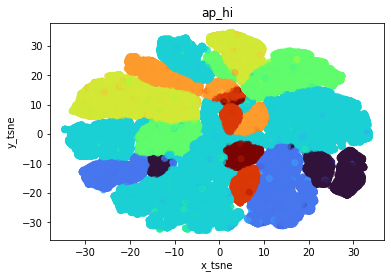

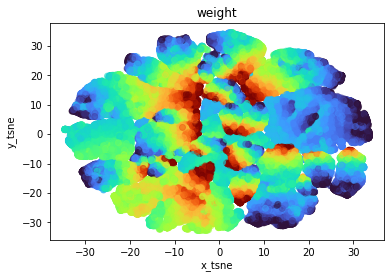

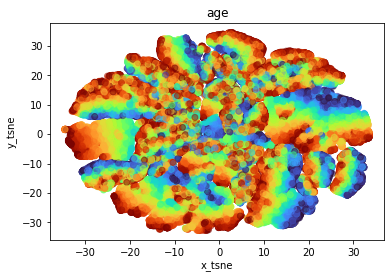

In [13]:
tsne_features = pd.read_csv('tsne/tsne_features_lr50.csv')

for col in ['ap_hi', 'weight', 'age']:
    plt.scatter(x=tsne_features['x_tsne'], y=tsne_features['y_tsne'], 
                c=train_out_corr[[col]].values, alpha=0.5,
                cmap='turbo')
    plt.title(col)
    plt.xlabel('x_tsne')
    plt.ylabel('y_tsne')
    plt.show()

Результаты кластеризации показывают, что наилучшее разделение данных удается получить с использованием данных о давлении (систолическое и диастолическое дают одинаковую картину) пациентов, вес и возраст пациентов дают дополнительную информацию о распределении данных внутри групп с одинаковым давлением.

## Модель случайного леса

In [14]:
X_train = train_out_corr.drop('cardio', axis=1)
y_train = train_out_corr['cardio']

cv_scores = cross_val_score(estimator=RandomForestClassifier(random_state=SEED), 
                            X=X_train, y=y_train, 
                            scoring=SCORE, 
                            cv=5, 
                            n_jobs=-1)
print("Среднее значение {}_score для всех признаков:".format(SCORE))
print("RandomForestClassifier")
print(np.mean(cv_scores).round(3))

Среднее значение roc_auc_score для всех признаков:
RandomForestClassifier
0.765


Произведем отбор признаков, дающих наибольшее значение метрики ROC-AUC:
- вычислим метрику для модели случайного леса по умолчанию
- выберем один признак дающий наибольшее значение метрики
- будем добавлять по одному признаку который дает наибольшее значение метрики
- построим график зависимости метрики от количества признаков
- выберем наименьшее количество признаков при условии наибольшего значения метрики

Создадим функцию для отбора признаков.

In [15]:
def feature_search(X, y, candidate_features, used_features,
                  estimator, scorer):
    '''
    Функция принимает на вход признаки и целевой признак исследуемого датасета,
    список признаков для поиска и список используемых признаков,
    модель и метрику для отбора признаков.
    Ищет признак с наибольшим значением метрики.
    Выводит кортеж первый элемент которого найденный признак, 
    а второй значение метрики.
    '''
    best_feature = None
    best_roc_auc = -1
    features_score_dict = {}
    
    for f in candidate_features:
        cv_scores = cross_val_score(estimator=estimator, 
                                    X=X[current_features + [f]], 
                                    y=y, 
                                    scoring=scorer, 
                                    cv=5, 
                                    n_jobs=-1)
        if np.mean(cv_scores) > best_roc_auc:
            best_roc_auc = np.mean(cv_scores)
            best_feature = f
    
    return (best_feature, best_roc_auc)

Используем функцию чтобы отобрать признаки.

In [16]:
# features = num_cols + cat_cols + bool_cols
# current_features = []
# results_features = []
# results_auc = []

# while len(features) !=0:
#     best_feature, best_auc = feature_search(X=X_train, y=y_train,        
#                                             candidate_features=features, 
#                                             used_features=current_features,
#                                             estimator=RandomForestClassifier(random_state=SEED),
#                                             scorer=SCORE)
#     results_features.append(current_features + [best_feature])
#     results_auc.append(best_auc)
#     features.remove(best_feature)
#     current_features.append(best_feature)

# feature_selection_df = pd.DataFrame([results_features, results_auc]).transpose()
# feature_selection_df.columns=['features', 'roc-auc']
# feature_selection_df['n_features'] = feature_selection_df['features'].apply(len)
# feature_selection_df.to_csv('feature_selection/forest_auc.csv')

In [17]:
feature_selection_df = pd.read_csv('feature_selection/forest_auc.csv', index_col=0)
feature_selection_df.index = feature_selection_df['n_features']
feature_selection_df['roc-auc'] = feature_selection_df['roc-auc'].round(2)
feature_selection_df[['features', 'roc-auc']].head(5)

,features,roc-auc
n_features,,
1,['ap_hi'],0.75
2,"['ap_hi', 'age']",0.78
3,"['ap_hi', 'age', 'cholesterol']",0.79
4,"['ap_hi', 'age', 'cholesterol', 'active']",0.79
5,"['ap_hi', 'age', 'cholesterol', 'active', 'alco']",0.79


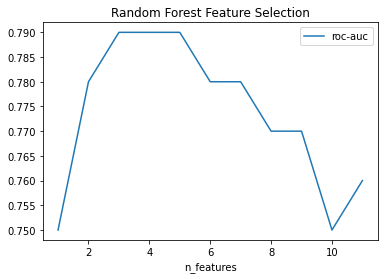

In [18]:
feature_selection_df.plot('n_features', 'roc-auc')
plt.title('Random Forest Feature Selection')
plt.show()

Будем использовать 5 отобранных признаков, т.к. с их увеличением метрика начинает непрерывно снижаться.

In [19]:
features_select = ['ap_hi', 'age', 'cholesterol', 'active', 'alco']

Подберем гиперпараметры модели используя отобранные признаки.

In [20]:
# params_forest = {'n_estimators': [100, 200, 300, 400, 500],
#                  'max_depth': [3, 5, 7, 9, 11],
#                  'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11],
#                  'min_samples_split': [2, 3, 4, 5]}

# grid_forest = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
#                            param_grid=params_forest,
#                            scoring=SCORE,
#                            cv=5,
#                            n_jobs=-1,
#                            verbose=1)
# grid_forest.fit(X_train[features_select], y_train)
# best_forest = grid_forest.best_estimator_
# dump(best_forest, "models/best_forest.joblib")

# print("Гиперпараметры лучшей модели")
# print(grid_forest.best_params_)

Оценим качество найденной модели.

In [21]:
best_forest = load("models/best_forest.joblib")
cv_forest = cross_val_score(estimator=best_forest, 
                            X=X_train[features_select], y=y_train, 
                            scoring=SCORE, 
                            cv=5, 
                            n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_forest,
              SCORE,
              cv_forest, 
              np.mean(cv_forest)))

* Модель:     
RandomForestClassifier(max_depth=7, min_samples_leaf=9, n_estimators=300,
                       random_state=12345)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.7927552  0.80085399 0.80188002 0.79751207 0.79219832]     
Среднее значение     
0.7970399186311843


Сделаем предсказание и сохраним в файл для отправки

In [22]:
sample_submission_1 = sample_submission.copy()
sample_submission_1['cardio'] = best_forest.predict_proba(test_out_corr[features_select])[:, 1]
sample_submission_1.to_csv('datasets/sample_submission_1.csv', index=False)

In [23]:
pd.read_csv('datasets/sample_submission_1.csv').head()

,id,cardio
0,5,0.499454
1,6,0.502761
2,7,0.446796
3,10,0.503563
4,11,0.216470


Результат на тестовой выборке (Kaggle): 0.80316

## Модель градиентного бустинга

Проверим какое качество модели дает модель градиентного бустинга по умолчанию.

In [24]:
cv_scores = cross_val_score(estimator=GradientBoostingClassifier(random_state=SEED), 
                            X=X_train, y=y_train, 
                            scoring=SCORE, 
                            cv=5, 
                            n_jobs=-1)
print("Среднее значение {}_score для всех признаков:".format(SCORE))
print("GradientBoostingClassifier")
print(np.mean(cv_scores).round(3))

Среднее значение roc_auc_score для всех признаков:
GradientBoostingClassifier
0.803


Можно видеть, что качество предсказаний заметно улучшилось по сравнению со случайным лесом. Проведем отбор признаков с использованием градиентного бустинга.

In [25]:
# features = num_cols + cat_cols + bool_cols
# current_features = []
# results_features = []
# results_auc = []

# while len(features) !=0:
#     best_feature, best_auc = feature_search(X=X_train, y=y_train,        
#                                             candidate_features=features, 
#                                             used_features=current_features,
#                                             estimator=GradientBoostingClassifier(random_state=SEED),
#                                             scorer=SCORE)
#     results_features.append(current_features + [best_feature])
#     results_auc.append(best_auc)
#     features.remove(best_feature)
#     current_features.append(best_feature)

# feature_selection_df = pd.DataFrame([results_features, results_auc]).transpose()
# feature_selection_df.columns=['features', 'roc-auc']
# feature_selection_df['n_features'] = feature_selection_df['features'].apply(len)
# feature_selection_df.to_csv('feature_selection/boosting_auc.csv', index=False)

In [26]:
feature_selection_b = pd.read_csv('feature_selection/boosting_auc.csv')
feature_selection_b.index = feature_selection_b['n_features']
feature_selection_b['roc-auc'] = feature_selection_b['roc-auc'].round(3)
feature_selection_b[['features', 'roc-auc']].head(6)

,features,roc-auc
n_features,,
1,['ap_hi'],0.752
2,"['ap_hi', 'age']",0.785
3,"['ap_hi', 'age', 'cholesterol']",0.796
4,"['ap_hi', 'age', 'cholesterol', 'weight']",0.799
5,"['ap_hi', 'age', 'cholesterol', 'weight', 'ap_...",0.800
6,"['ap_hi', 'age', 'cholesterol', 'weight', 'ap_...",0.801


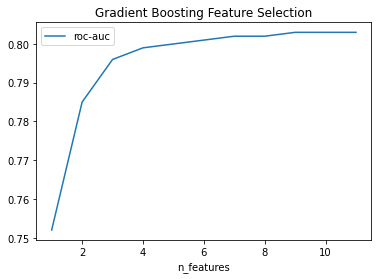

In [27]:
feature_selection_b.plot('n_features', 'roc-auc')
plt.title('Gradient Boosting Feature Selection')
plt.show()

Наибольшая скорость роста метрики наблюдается до 6 признаков, после чего метрика изменяется намного медленнее (при увеличении количества признаков с 1 по 6 метрика увеличилась на 0,05, а при увеличении их количества с 7 по 11 на 0,002). Сократим количество признаков для повышения обобщающей способности модели.

In [28]:
features_select_b = ['ap_hi', 'age', 'cholesterol', 'weight', 'ap_lo', 'active']

Подберем гиперпараметры модели используя отобранные признаки.

In [29]:
# params_boosting = {'learning_rate': [0.01, 0.1, 0.2],
#                    'n_estimators': [100, 150, 200],
#                    'max_depth': [3, 4, 5],
#                    'min_samples_leaf': [6, 7, 8],
#                    'min_samples_split': [2, 3]}

# grid_boosting = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED),
#                            param_grid=params_boosting,
#                            scoring=SCORE,
#                            cv=5,
#                            n_jobs=-1,
#                            verbose=1)
# grid_boosting.fit(X_train[features_select_b], y_train)
# best_boosting = grid_boosting.best_estimator_
# dump(best_boosting, "models/best_boosting.joblib")

# print("Гиперпараметры лучшей модели")
# print(grid_boosting.best_params_)

In [30]:
best_boosting = load("models/best_boosting.joblib")
cv_boosting = cross_val_score(estimator=best_boosting, 
                              X=X_train[features_select_b], y=y_train, 
                              scoring=SCORE, 
                              cv=5, 
                              n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_boosting,
              SCORE,
              cv_boosting, 
              np.mean(cv_boosting)))

* Модель:     
GradientBoostingClassifier(min_samples_leaf=7, n_estimators=150,
                           random_state=12345)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.7966679  0.80554472 0.80423455 0.80280409 0.79725175]     
Среднее значение     
0.8013006036292356


Получим предсказание с использованием полученной модели градиентного бустинга

In [31]:
sample_submission_2 = sample_submission.copy()
sample_submission_2['cardio'] = best_boosting.predict_proba(test_out_corr[features_select_b])[:, 1]
sample_submission_2.to_csv('datasets/sample_submission_2.csv', index=False)

In [32]:
pd.read_csv('datasets/sample_submission_2.csv').head()

,id,cardio
0,5,0.493776
1,6,0.542546
2,7,0.399813
3,10,0.556202
4,11,0.219919


Результат на тестовой выборке (Kaggle): 0.80764

Подберем гиперпараметры модели градиентного бустинга используя все признаки. Будем варьировать долю использованных признаков

In [33]:
# params_boosting_wfs = {'learning_rate': [0.01, 0.1, 0.2],
#                        'subsample': [0.5, 0.8, 1.0],
#                        'n_estimators': [50, 100, 150],
#                        'max_depth': [3, 4, 5],
#                        'min_samples_leaf': [5, 6, 7],
#                        'min_samples_split': [2, 3]}

# grid_boosting_wfs = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED),
#                                  param_grid=params_boosting_wfs,
#                                  scoring=SCORE,
#                                  cv=5,
#                                  n_jobs=-1,
#                                  verbose=1)
# grid_boosting_wfs.fit(X_train, y_train)
# best_boosting_wfs = grid_boosting_wfs.best_estimator_
# dump(best_boosting_wfs, "models/best_boosting_wfs.joblib")

# print("Гиперпараметры лучшей модели")
# print(grid_boosting_wfs.best_params_)

In [34]:
best_boosting_wfs = load("models/best_boosting_wfs.joblib")
cv_boosting_wfs = cross_val_score(estimator=best_boosting_wfs, 
                                  X=X_train, y=y_train, 
                                  scoring=SCORE, 
                                  cv=5, 
                                  n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_boosting_wfs,
              SCORE,
              cv_boosting_wfs, 
              np.mean(cv_boosting_wfs)))

* Модель:     
GradientBoostingClassifier(max_depth=4, min_samples_leaf=6, random_state=12345)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.79869619 0.80818115 0.80637919 0.80562563 0.79929045]     
Среднее значение     
0.8036345211528293


Получим предсказание с использованием полученной модели градиентного бустинга

In [35]:
sample_submission_3 = sample_submission.copy()
sample_submission_3['cardio'] = best_boosting_wfs.predict_proba(test_out_corr)[:, 1]
sample_submission_3.to_csv('datasets/sample_submission_3.csv', index=False)

In [36]:
pd.read_csv('datasets/sample_submission_3.csv').head()

,id,cardio
0,5,0.504724
1,6,0.552830
2,7,0.428071
3,10,0.548324
4,11,0.226247


Результат на тестовой выборке (Kaggle): 0.81004

Можно видеть что использование всех имеющихся признаков в модели градиентного бустинга увеличивает величину метрики. Можно заключить, что отбор признаков необходимо проводить до количества снижаеющего величину метрики.

## Генерация признаков

Сгенерируем полиномиальные признаки второй степени. После этого произведем отбор признаков с помощью моделей случайного леса и градиентного бустинга с целью максимизации метрики ROC-AUC

In [37]:
preprocess = PolynomialFeatures(degree=2, include_bias=False)

X_train_fg = pd.DataFrame(preprocess.fit_transform(X_train[num_cols]))
X_test_fg = pd.DataFrame(preprocess.fit_transform(test_out_corr[num_cols]))

preprocess_num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo',
                       'age**2', 'age*height', 'age*weight', 'age*ap_hi', 'age*ap_lo',
                       'height**2', 'height*weight', 'height*ap_hi', 'height*ap_lo',
                       'weight**2', 'weight*ap_hi', 'weight*ap_lo',
                       'ap_hi**2', 'ap_hi*ap_lo',
                       'ap_lo**2']

for i in [X_train_fg, X_test_fg]:
    i.columns = preprocess_num_cols
    i[preprocess_num_cols] = i[preprocess_num_cols].astype('int64')

X_train_fg.index = X_train.index
X_test_fg.index = test_out_corr.index

X_train_fg = pd.concat([X_train_fg, X_train[cat_cols + bool_cols]], axis=1)
X_test_fg = pd.concat([X_test_fg, test_out_corr[cat_cols + bool_cols]], axis=1)

X_test_fg.head()

,age,height,weight,ap_hi,ap_lo,age**2,age*height,age*weight,age*ap_hi,age*ap_lo,...,weight*ap_lo,ap_hi**2,ap_hi*ap_lo,ap_lo**2,gender,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,,,,,,,,,,,
5,51,154,85,130,80,2601,7854,4335,6630,4080,...,6800,16900,10400,6400,1,1,1,False,False,True
6,52,170,69,130,90,2704,8840,3588,6760,4680,...,6210,16900,11700,8100,2,1,1,False,False,True
7,55,160,70,120,75,3025,8800,3850,6600,4125,...,5250,14400,9000,5625,1,1,1,False,False,False
10,49,180,94,130,90,2401,8820,4606,6370,4410,...,8460,16900,11700,8100,2,1,1,False,False,True
11,44,170,76,120,80,1936,7480,3344,5280,3520,...,6080,14400,9600,6400,2,1,1,False,False,True


Произведем отбор признаков с помощью модели случайного леса

In [38]:
# features = list(X_train_fg.columns)
# current_features = []
# results_features = []
# results_auc = []

# while len(features) !=0:
#     best_feature, best_auc = feature_search(X=X_train_fg, y=y_train,        
#                                             candidate_features=features, 
#                                             used_features=current_features,
#                                             estimator=RandomForestClassifier(random_state=SEED),
#                                             scorer=SCORE)
#     results_features.append(current_features + [best_feature])
#     results_auc.append(best_auc)
#     features.remove(best_feature)
#     current_features.append(best_feature)

# fs_forest_fg_df = pd.DataFrame([results_features, results_auc]).transpose()
# fs_forest_fg_df.columns=['features', 'roc-auc']
# fs_forest_fg_df['n_features'] = fs_forest_fg_df['features'].apply(len)
# fs_forest_fg_df.to_csv('feature_selection/forest_auc_fg.csv')

In [39]:
fs_forest_fg_df = pd.read_csv('feature_selection/forest_auc_fg.csv', index_col=0)
fs_forest_fg_df.index = fs_forest_fg_df['n_features']
fs_forest_fg_df['roc-auc'] = fs_forest_fg_df['roc-auc'].round(3)
fs_forest_fg_df[['features', 'roc-auc']].head(7)

,features,roc-auc
n_features,,
1,['age*ap_hi'],0.774
2,"['age*ap_hi', 'cholesterol']",0.783
3,"['age*ap_hi', 'cholesterol', 'ap_hi']",0.792
4,"['age*ap_hi', 'cholesterol', 'ap_hi', 'age']",0.792
5,"['age*ap_hi', 'cholesterol', 'ap_hi', 'age', '...",0.792
6,"['age*ap_hi', 'cholesterol', 'ap_hi', 'age', '...",0.792
7,"['age*ap_hi', 'cholesterol', 'ap_hi', 'age', '...",0.790


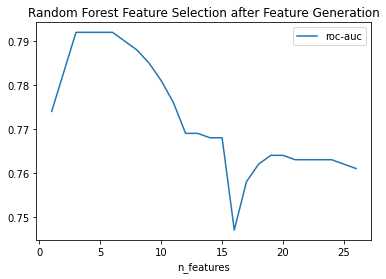

In [40]:
fs_forest_fg_df.plot('n_features', 'roc-auc')
plt.title('Random Forest Feature Selection after Feature Generation')
plt.show()

Наибольшая величина метрики достигается при 6 признаках и она превосходит найденную выше с использованием случайного леса и исходного набора признаков

In [41]:
features_forest_fg = ['age*ap_hi', 'cholesterol', 'ap_hi', 'age', 'age**2', 'ap_hi**2']

Подберем гиперпараметры модели используя отобранные признаки.

In [42]:
# params_forest_fg = {'n_estimators': [80, 100, 120],
#                     'max_depth': [6, 7, 8],
#                     'min_samples_leaf': [6, 7, 8],
#                     'min_samples_split': [2, 3, 4]}

# grid_forest_fg = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
#                               param_grid=params_forest_fg,
#                               scoring=SCORE,
#                               cv=5,
#                               n_jobs=-1,
#                               verbose=1)
# grid_forest_fg.fit(X_train_fg[features_forest_fg], y_train)
# best_forest_fg = grid_forest_fg.best_estimator_
# dump(best_forest_fg, "models/best_forest_fg.joblib")

# print("Гиперпараметры лучшей модели")
# print(grid_forest_fg.best_params_)

Оценим качество найденной модели.

In [43]:
best_forest_fg = load("models/best_forest_fg.joblib")
cv_forest_fg = cross_val_score(estimator=best_forest_fg, 
                               X=X_train_fg[features_forest_fg], y=y_train, 
                               scoring=SCORE, 
                               cv=5, 
                               n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_forest_fg,
              SCORE,
              cv_forest_fg, 
              np.mean(cv_forest_fg)))

* Модель:     
RandomForestClassifier(max_depth=7, min_samples_leaf=7, random_state=12345)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.79102366 0.79893106 0.80000158 0.79614455 0.79253289]     
Среднее значение     
0.795726746288137


Получим предсказание с использованием полученной модели градиентного бустинга

In [44]:
sample_submission_4 = sample_submission.copy()
sample_submission_4['cardio'] = best_forest_fg.predict_proba(X_test_fg[features_forest_fg])[:, 1]
sample_submission_4.to_csv('datasets/sample_submission_4.csv', index=False)

In [45]:
pd.read_csv('datasets/sample_submission_4.csv').head()

,id,cardio
0,5,0.498250
1,6,0.500992
2,7,0.380509
3,10,0.493421
4,11,0.236106


Результат на тестовой выборке (Kaggle): 0.80220. Результат ухудшился по сравнению с аналогичным подходом к исходному датасету (без генерации признаков).

Подберем признаки в модели градиентного бустинга

In [46]:
# features = list(X_train_fg.columns)
# current_features = []
# results_features = []
# results_auc = []

# while len(features) !=0:
#     best_feature, best_auc = feature_search(X=X_train_fg, y=y_train,        
#                                             candidate_features=features, 
#                                             used_features=current_features,
#                                             estimator=GradientBoostingClassifier(random_state=SEED),
#                                             scorer=SCORE)
#     results_features.append(current_features + [best_feature])
#     results_auc.append(best_auc)
#     features.remove(best_feature)
#     current_features.append(best_feature)

# fs_boosting_fg_df = pd.DataFrame([results_features, results_auc]).transpose()
# fs_boosting_fg_df.columns=['features', 'roc-auc']
# fs_boosting_fg_df['n_features'] = fs_boosting_fg_df['features'].apply(len)
# fs_boosting_fg_df.to_csv('feature_selection/boosting_auc_fg.csv', index=False)

In [47]:
fs_boosting_fg_df = pd.read_csv('feature_selection/boosting_auc_fg.csv')
fs_boosting_fg_df.index = fs_boosting_fg_df['n_features']
fs_boosting_fg_df['roc-auc'] = fs_boosting_fg_df['roc-auc'].round(3)
fs_boosting_fg_df[['features', 'roc-auc']].head(11)

,features,roc-auc
n_features,,
1,['age*ap_hi'],0.769
2,"['age*ap_hi', 'ap_hi*ap_lo']",0.786
3,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol']",0.795
4,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.797
5,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.799
6,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.800
7,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.801
8,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.802
9,"['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'w...",0.802


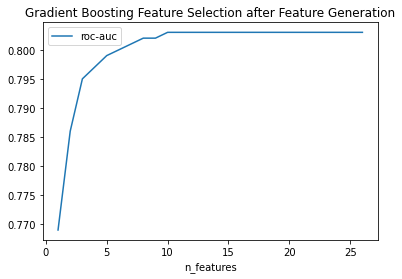

In [48]:
fs_boosting_fg_df.plot('n_features', 'roc-auc')
plt.title('Gradient Boosting Feature Selection after Feature Generation')
plt.show()

Можно видеть, что начиная с 10 признаков значение метрики не изменяется до 3 знака после запятой. Используем найденные признаки для подбора гиперпараметров.

In [49]:
features_boosting_fg = ['age*ap_hi', 'ap_hi*ap_lo', 'cholesterol', 'weight', 'ap_hi', 'active', 'gluc', 'age', 'alco', 'gender']

In [50]:
# params_boosting_fg = {'learning_rate': [0.05, 0.1, 0.15],
#                       'subsample': [0.8, 0.9, 1.0],
#                       'n_estimators': [100, 200, 300],
#                       'max_depth': [3, 4, 5],
#                       'min_samples_leaf': [5, 6, 7],
#                       'min_samples_split': [2, 3]}

# grid_boosting_fg = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED),
#                                  param_grid=params_boosting_fg,
#                                  scoring=SCORE,
#                                  cv=5,
#                                  n_jobs=-1,
#                                  verbose=1)
# grid_boosting_fg.fit(X_train_fg[features_boosting_fg], y_train)
# best_boosting_fg = grid_boosting_fg.best_estimator_
# dump(best_boosting_fg, "models/best_boosting_fg.joblib")

# print("Гиперпараметры лучшей модели")
# print(grid_boosting_fg.best_params_)

In [51]:
best_boosting_fg = load("models/best_boosting_fg.joblib")
cv_boosting_fg = cross_val_score(estimator=best_boosting_fg, 
                                 X=X_train_fg[features_boosting_fg], y=y_train, 
                                 scoring=SCORE, 
                                 cv=5, 
                                 n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_boosting_fg,
              SCORE,
              cv_boosting_fg, 
              np.mean(cv_boosting_fg)))

* Модель:     
GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=6,
                           n_estimators=200, random_state=12345, subsample=0.9)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.79885835 0.80772727 0.80678984 0.80422003 0.79928243]     
Среднее значение     
0.8033755825519535


Получим предсказание с использованием полученной модели градиентного бустинга

In [52]:
sample_submission_5 = sample_submission.copy()
sample_submission_5['cardio'] = best_boosting_fg.predict_proba(X_test_fg[features_boosting_fg])[:, 1]
sample_submission_5.to_csv('datasets/sample_submission_5.csv', index=False)

In [53]:
pd.read_csv('datasets/sample_submission_5.csv').head()

,id,cardio
0,5,0.464223
1,6,0.512024
2,7,0.424063
3,10,0.551453
4,11,0.217606


Результат на тестовой выборке (Kaggle): 0.80930. Результат улучшился по сравнению с аналогичным подходом к исходному датасету.

Применим модель градиентного бустинга ко всем сгенерированным признакам без отбора.

In [54]:
params_boosting_fg_wfs = {'learning_rate': [0.01, 0.03, 0.05],
                          'subsample': [0.8, 0.9, 1.0],
                          'n_estimators': [100, 200, 300],
                          'max_depth': [3, 4, 5],
                          'min_samples_leaf': [5, 6, 7],
                          'min_samples_split': [2, 3]}

grid_boosting_fg_wfs = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED),
                                    param_grid=params_boosting_fg_wfs,
                                    scoring=SCORE,
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=1)
grid_boosting_fg_wfs.fit(X_train_fg, y_train)
best_boosting_fg_wfs = grid_boosting_fg_wfs.best_estimator_
dump(best_boosting_fg_wfs, "models/best_boosting_fg_wfs.joblib")

print("Гиперпараметры лучшей модели")
print(grid_boosting_fg_wfs.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Гиперпараметры лучшей модели
{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}


In [55]:
best_boosting_fg_wfs = load("models/best_boosting_fg_wfs.joblib")
cv_boosting_fg_wfs = cross_val_score(estimator=best_boosting_fg_wfs, 
                                     X=X_train_fg, y=y_train, 
                                     scoring=SCORE, 
                                     cv=5, 
                                     n_jobs=-1)
print("* Модель:\
     \n{}\
     \n* {}_score на обучающей выборке:\
     \nКросс-валидация\
     \n{}\
     \nСреднее значение\
     \n{}"
      .format(best_boosting_fg_wfs,
              SCORE,
              cv_boosting_fg_wfs, 
              np.mean(cv_boosting_fg_wfs)))

* Модель:     
GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=6,
                           n_estimators=200, random_state=12345, subsample=0.9)     
* roc_auc_score на обучающей выборке:     
Кросс-валидация     
[0.79861254 0.80782471 0.80598926 0.80484469 0.79896529]     
Среднее значение     
0.8032472999783862
